In [1]:
import zipfile
local_zip='/content/NSE-Tata-Global-Beverages-Limited.zip'
zip_ref=zipfile.ZipFile(local_zip,'r')
zip_ref.extractall()
zip_ref.close()


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM


In [40]:
df = pd.read_csv('/content/NSE-Tata-Global-Beverages-Limited.csv')

#print the head
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


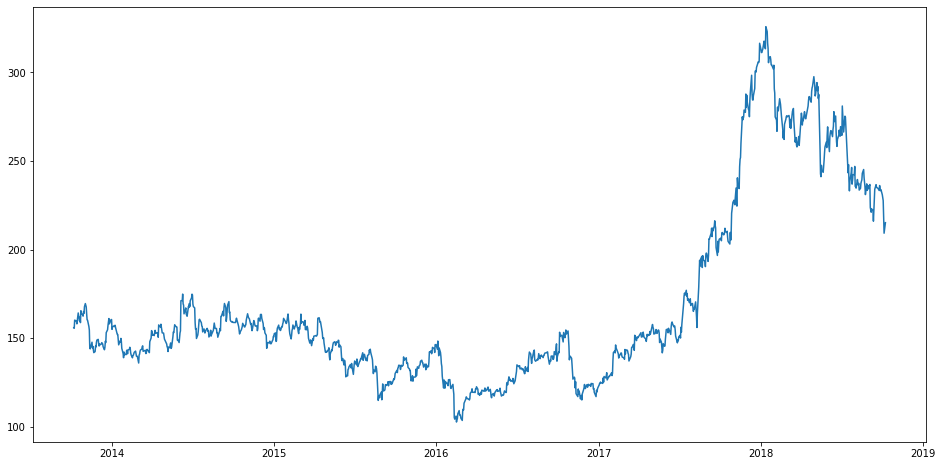

In [41]:
#setting index as date
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

#plot
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history')

In [42]:
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

In [43]:
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values


In [44]:
train = dataset[0:987,:] # four year data
valid = dataset[987:,:]  # we take one year data for testing


In [45]:
#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)



Multi-Step LSTM Models

A time series forecasting problem that requires a prediction of multiple time steps into the future can be referred to as multi-step time series forecasting.

There are two main types of LSTM models that can be used for multi-step forecasting; they are:

   1 Vector Output Model

   2 Encoder-Decoder Model
   
 We use first model 


In [46]:
x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0]) # Here we take 60 days data to predict next 5 days 
    y_train.append(scaled_data[i:i+5,0])   # 5 days to predict
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1)) # (3 dim data)


In [47]:
model = Sequential()
model.add(LSTM(50,return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50))
model.add(Dense(5))# we have to predict next 5 days 



In [48]:
model.compile(loss='mse', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)


927/927 - 22s - loss: 0.0019


In [55]:
model.save("saved_model.h5") # save the model

In [49]:
inputs = new_data[len(new_data) - len(valid) - 60:].values # test data 308 samples
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)


In [50]:
X_test =[]
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0]) # same as for test data #60 days
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)



In [51]:
rms=np.sqrt(np.mean(np.power((valid-closing_price[0:248,0]),2)))
rms

38.433386764564126

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


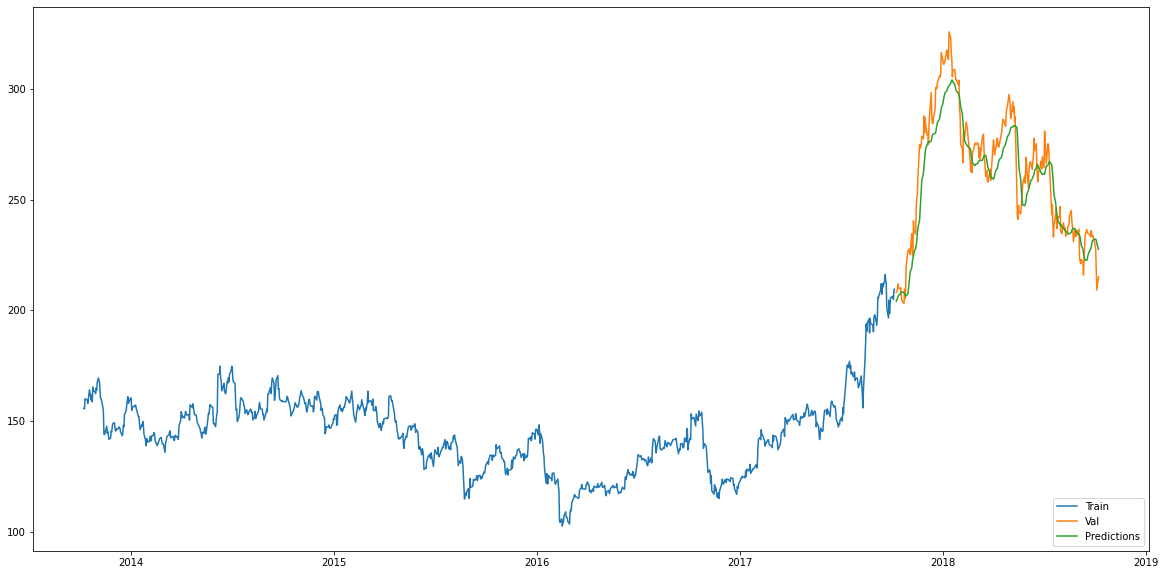

In [52]:
#for plotting
train = new_data[:987]
valid = new_data[987:]
valid['Predictions'] = closing_price[0:248,0]
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')


In [37]:
#we get next 5 days predictions using 60 days data
closing_price

array([[198.29602, 202.20767, 204.40036, 204.50351, 203.21106],
       [199.04514, 202.93918, 205.25153, 205.21358, 203.81378],
       [199.74417, 203.62712, 206.02727, 205.91725, 204.43779],
       ...,
       [226.39081, 231.9307 , 236.1129 , 235.32233, 234.99684],
       [224.42061, 230.0274 , 233.89745, 233.47166, 233.44162],
       [221.09947, 226.76953, 230.17503, 230.25613, 230.61975]],
      dtype=float32)

In [53]:
valid

,Close,Predictions
Date,,
2017-10-09,208.3,204.181168
2017-10-10,208.45,204.740952
2017-10-11,209.4,205.312927
2017-10-12,212,205.921738
2017-10-13,210.25,206.707977
...,...,...
2018-10-01,230.9,232.164490
2018-10-03,227.6,232.193695
2018-10-04,218.2,231.728241


In [54]:
!pip install dash
!pip install dash-html-components
!pip install dash-core-components


     |████████████████████████████████| 81kB 3.6MB/s 
     |████████████████████████████████| 1.0MB 7.9MB/s 
     |████████████████████████████████| 3.5MB 14.4MB/s 
     |████████████████████████████████| 194kB 34.7MB/s 
     |████████████████████████████████| 1.8MB 38.6MB/s 
     |████████████████████████████████| 358kB 39.0MB/s 
  Created wheel for dash: filename=dash-1.19.0-cp37-none-any.whl size=84011 sha256=209c8c4da4cf39a7faf86484bda8a95aedc35739f29ba7078c6457d1e32492a7
  Stored in directory: /root/.cache/pip/wheels/f7/50/a7/a230ff7f503b10120bff18c2524a375bb85a61ce6b519c8a77
  Created wheel for flask-compress: filename=Flask_Compress-1.9.0-cp37-none-any.whl size=7259 sha256=763524c0f136024db21a87e63006af8e040192a8a01c681c832ff3cd1060bdf5
  Stored in directory: /root/.cache/pip/wheels/0d/56/7d/e0c50541e5421b8291d958afb098c23818989e29d91a1edac5
  Created wheel for dash-renderer: filename=dash_renderer-1.9.0-cp37-none-any.whl size=1014870 sha256=60c7074ed82a7ffc2a26e61fa09a9693f7d5f

In [56]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.graph_objs as go
from dash.dependencies import Input, Output
from keras.models import load_model
app = dash.Dash()
server = app.server


In [57]:
import zipfile
local_zip='/content/stock_data.zip'
zip_ref1=zipfile.ZipFile(local_zip,'r')
zip_ref1.extractall()
zip_ref1.close()


In [58]:
df=pd.read_csv('/content/stock_data.csv')

In [ ]:
app.layout = html.Div([
   
    html.H1("Stock Price Analysis Dashboard", style={"textAlign": "center"}),
   
    dcc.Tabs(id="tabs", children=[
       
        dcc.Tab(label='NSE-TATAGLOBAL Stock Data',children=[
            html.Div([
                html.H2("Actual closing price",style={"textAlign": "center"}),
                dcc.Graph(
                    id="Actual Data",
                    figure={
                        "data":[
                            go.Scatter(
                                x=train.index,
                                y=valid["Close"],
                                mode='markers'
                            )
                        ],
                        "layout":go.Layout(
                            title='scatter plot',
                            xaxis={'title':'Date'},
                            yaxis={'title':'Closing Rate'}
                        )
                    }
                ),
                html.H2("LSTM Predicted closing price",style={"textAlign": "center"}),
                dcc.Graph(
                    id="Predicted Data",
                    figure={
                        "data":[
                            go.Scatter(
                                x=valid.index,
                                y=valid["Predictions"],
                                mode='markers'
                            )
                        ],
                        "layout":go.Layout(
                            title='scatter plot',
                            xaxis={'title':'Date'},
                            yaxis={'title':'Closing Rate'}
                        )
                    }
                )                
            ])                
        ]),
        dcc.Tab(label='Facebook Stock Data', children=[
            html.Div([
                html.H1("Facebook Stocks High vs Lows", 
                        style={'textAlign': 'center'}),
              
                dcc.Dropdown(id='my-dropdown',
                             options=[{'label': 'Tesla', 'value': 'TSLA'},
                                      {'label': 'Apple','value': 'AAPL'}, 
                                      {'label': 'Facebook', 'value': 'FB'}, 
                                      {'label': 'Microsoft','value': 'MSFT'}], 
                             multi=True,value=['FB'],
                             style={"display": "block", "margin-left": "auto", 
                                    "margin-right": "auto", "width": "60%"}),
                dcc.Graph(id='highlow'),
                html.H1("Facebook Market Volume", style={'textAlign': 'center'}),
         
                dcc.Dropdown(id='my-dropdown2',
                             options=[{'label': 'Tesla', 'value': 'TSLA'},
                                      {'label': 'Apple','value': 'AAPL'}, 
                                      {'label': 'Facebook', 'value': 'FB'},
                                      {'label': 'Microsoft','value': 'MSFT'}], 
                             multi=True,value=['FB'],
                             style={"display": "block", "margin-left": "auto", 
                                    "margin-right": "auto", "width": "60%"}),
                dcc.Graph(id='volume')
            ], className="container"),
        ])
    ])
])
@app.callback(Output('highlow', 'figure'),
              [Input('my-dropdown', 'value')])
def update_graph(selected_dropdown):
    dropdown = {"TSLA": "Tesla","AAPL": "Apple","FB": "Facebook","MSFT": "Microsoft",}
    trace1 = []
    trace2 = []
    for stock in selected_dropdown:
        trace1.append(
          go.Scatter(x=df[df["Stock"] == stock]["Date"],
                     y=df[df["Stock"] == stock]["High"],
                     mode='lines', opacity=0.7, 
                     name=f'High {dropdown[stock]}',textposition='bottom center'))
        trace2.append(
          go.Scatter(x=df[df["Stock"] == stock]["Date"],
                     y=df[df["Stock"] == stock]["Low"],
                     mode='lines', opacity=0.6,
                     name=f'Low {dropdown[stock]}',textposition='bottom center'))
    traces = [trace1, trace2]
    data = [val for sublist in traces for val in sublist]
    figure = {'data': data,
              'layout': go.Layout(colorway=["#5E0DAC", '#FF4F00', '#375CB1', 
                                            '#FF7400', '#FFF400', '#FF0056'],
            height=600,
            title=f"High and Low Prices for {', '.join(str(dropdown[i]) for i in selected_dropdown)} Over Time",
            xaxis={"title":"Date",
                   'rangeselector': {'buttons': list([{'count': 1, 'label': '1M', 
                                                       'step': 'month', 
                                                       'stepmode': 'backward'},
                                                      {'count': 6, 'label': '6M', 
                                                       'step': 'month', 
                                                       'stepmode': 'backward'},
                                                      {'step': 'all'}])},
                   'rangeslider': {'visible': True}, 'type': 'date'},
             yaxis={"title":"Price (USD)"})}
    return figure
@app.callback(Output('volume', 'figure'),
              [Input('my-dropdown2', 'value')])
def update_graph(selected_dropdown_value):
    dropdown = {"TSLA": "Tesla","AAPL": "Apple","FB": "Facebook","MSFT": "Microsoft",}
    trace1 = []
    for stock in selected_dropdown_value:
        trace1.append(
          go.Scatter(x=df[df["Stock"] == stock]["Date"],
                     y=df[df["Stock"] == stock]["Volume"],
                     mode='lines', opacity=0.7,
                     name=f'Volume {dropdown[stock]}', textposition='bottom center'))
    traces = [trace1]
    data = [val for sublist in traces for val in sublist]
    figure = {'data': data, 
              'layout': go.Layout(colorway=["#5E0DAC", '#FF4F00', '#375CB1', 
                                            '#FF7400', '#FFF400', '#FF0056'],
            height=600,
            title=f"Market Volume for {', '.join(str(dropdown[i]) for i in selected_dropdown_value)} Over Time",
            xaxis={"title":"Date",
                   'rangeselector': {'buttons': list([{'count': 1, 'label': '1M', 
                                                       'step': 'month', 
                                                       'stepmode': 'backward'},
                                                      {'count': 6, 'label': '6M',
                                                       'step': 'month', 
                                                       'stepmode': 'backward'},
                                                      {'step': 'all'}])},
                   'rangeslider': {'visible': True}, 'type': 'date'},
             yaxis={"title":"Transactions Volume"})}
    return figure
if __name__=='__main__':
    app.run_server(debug=True)  

In [70]:
from keras.layers import RepeatVector
from keras.layers import TimeDistributed


In [71]:
y_train = np.reshape(y_train, (y_train.shape[0],y_train.shape[1],1)) # (3 dim data)

Encoder-Decoder Model

A model specifically developed for forecasting variable length output sequences is called the Encoder-Decoder LSTM.

The model was designed for prediction problems where there are both input and output sequences, so-called sequence-to-sequence, or seq2seq problems, such as translating text from one language to another.

This model can be used for multi-step time series forecasting.



In [74]:
model1 = Sequential()
model1.add(LSTM(60,input_shape=(x_train.shape[1],1)))
model1.add(RepeatVector(5))
model1.add(LSTM(60, return_sequences=True))
model1.add(TimeDistributed(Dense(1)))
model1.compile(optimizer='adam', loss='mse')
# fit model

model1.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)



927/927 - 15s - loss: 0.0016


In [82]:
closing_price1 = model1.predict(X_test)
closing_price1 = scaler.inverse_transform(closing_price1[0])


In [83]:
closing_price1

array([[226.97974],
       [220.49509],
       [222.6258 ],
       [222.5351 ],
       [223.1453 ]], dtype=float32)